In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

((480, 640, 3), <matplotlib.image.AxesImage at 0x7906655eacb0>)

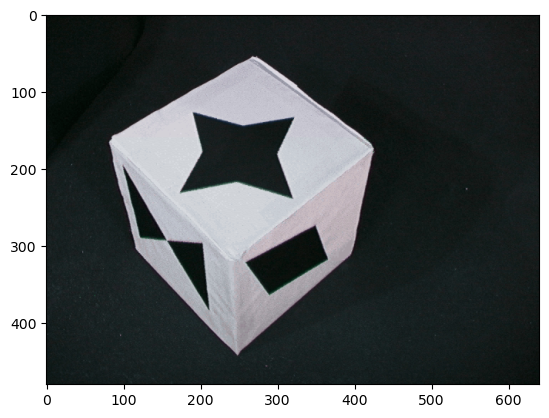

In [5]:
folder_path = "week06_data/"
box = cv2.imread(folder_path + "Box3.bmp")
box.shape, plt.imshow(box)

## Ex 7.1

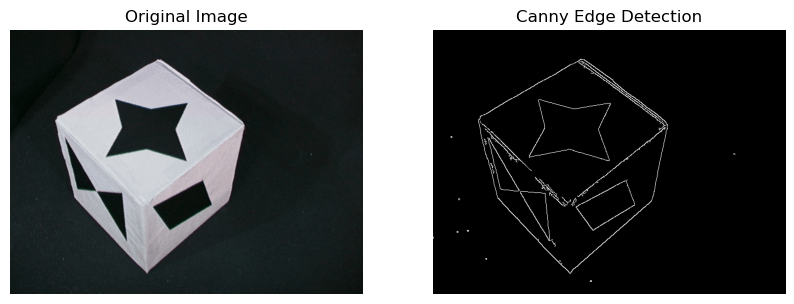

In [6]:
t_lower = 50  # Lower Threshold
t_upper = 150  # Upper threshold

edge = cv2.Canny(box, t_lower, t_upper)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(box)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(edge, cmap="gray")
ax2.set_title("Canny Edge Detection")
ax2.axis("off")
plt.show()

## Ex 7.2

In [7]:
import skimage.transform

ModuleNotFoundError: No module named 'skimage'

In [ ]:
hspace, angles, dists = skimage.transform.hough_line(edge)
hspace.shape, angles.shape, dists.shape

((1601, 180), (180,), (1601,))

## Ex 7.3

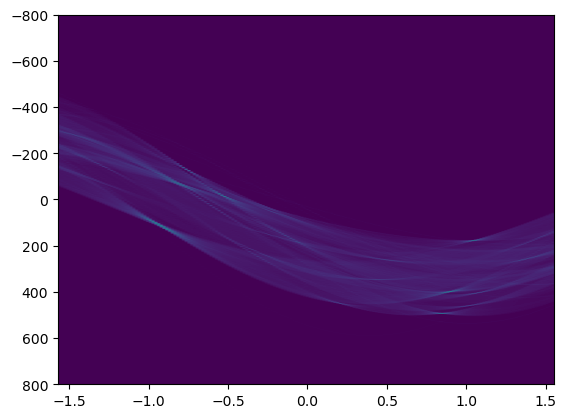

In [ ]:
extent = [angles[0], angles[-1], dists[-1], dists[0]]
plt.imshow(hspace, extent=extent, aspect='auto')

## Ex 7.4
In the Hough Transform, angle (θ) is the angle of the normal to the line, not the line’s slope angle. The slope of the line itself is perpendicular to this normal.
If θ is the angle of the normal, the line’s slope angle (let’s call it φ) is offset by 90° (or π/2 radians) from θ because the line is perpendicular to the normal.
Mathematically: 
𝜙 = 𝜃 + 𝜋/2
ϕ=θ+π/2.

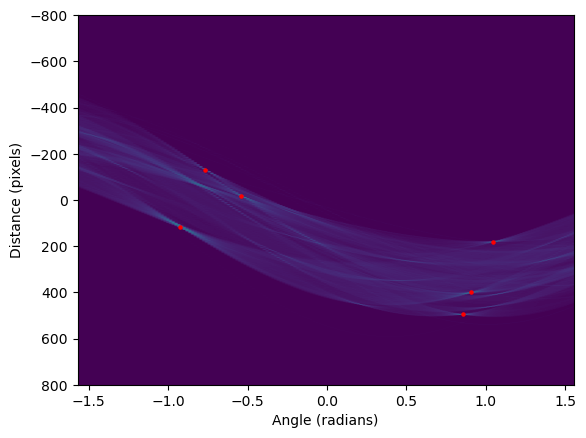

In [ ]:
n = 6
extH, extAngles, extDists = skimage.transform.hough_line_peaks(hspace, angles, dists, num_peaks=n)
plt.scatter(extAngles, extDists, c="r", s=5)

extent = [angles[0], angles[-1], dists[-1], dists[0]]
plt.xlabel("Angle (radians)")
plt.ylabel("Distance (pixels)")
plt.imshow(hspace, extent=extent, aspect="auto")
plt.show()

## Ex 7.5

In [ ]:
def DrawLine(l, shape):
#Checks where the line intersects the four sides of the image
# and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q

    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    if (len(P)==0):
        print("Line is completely outside image")
    plt.plot(*np.array(P).T)


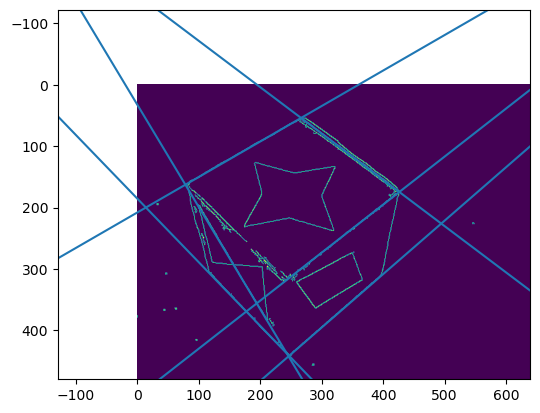

In [ ]:
plt.figure()
plt.imshow(edge)
for _, angle, dist in zip(*(extH, extAngles, extDists)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    plt.axline((x0, y0), slope=np.tan(angle + np.pi / 2))

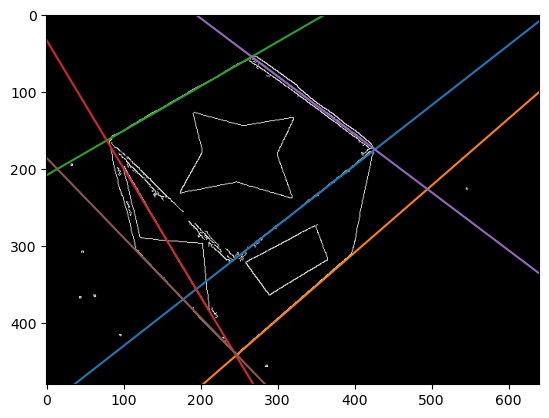

In [ ]:
plt.imshow(edge, cmap="gray")
for i in range(n):
    angle = extAngles[i]
    dist = extDists[i]
    l = np.array([np.cos(angle), np.sin(angle), -dist])
    DrawLine(l, box.shape)

# RANSAC

In [ ]:
import sys
import os

# Get the absolute path to the parent directory containing "02504 Computer Vision"
parent_dir = os.path.abspath(os.path.join("../..", "02504 Computer Vision"))

# Add it to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utility import Pi, Piinv

In [ ]:
def test_points(n_in, n_out):
    a = (np.random.rand(n_in)-.5)*10
    b = np.vstack((a, a*.5+np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T

In [ ]:
pts = test_points(10, 10)
pts.shape

(2, 20)

## Ex 7.6

In [ ]:
def fit_line(pt1: np.array, pt2: np.array):
    """
    Fit a line (in homogeneous coordinates) based on two given points, pt1 and pt2
    Args:
        pt1 (np.array): first point in the line
        pt2 (np.array): second point in line

    Return:
        l (np.array): line that intersects both points. Shape (3,)
    """
    if pt1.shape == (2,):
        pt1 = Piinv(pt1.reshape(2, 1))
    if pt2.shape == (2,):
        pt2 = Piinv(pt2.reshape(2, 1))
    l = np.cross(pt1.squeeze(), pt2.squeeze()).astype(np.float64)
    l /= np.linalg.norm(l)
    return l

In [ ]:
a = Piinv(np.asarray([1, 2]).reshape(2,1))
b = Piinv(np.asarray([3, 2]).reshape(2,1))
l1 = fit_line(a, b)
l1.shape, l1


((3,), array([ 0.        ,  0.4472136 , -0.89442719]))

## Ex 7.7
Make a function that determines which of a set of 2D points are an inliers or outliers with respect
to a given line. The threshold should be supplied as parameter to this function, such that it can
easily be tuned later

In [ ]:
def dist_to_line(pt: np.array, l: np.array):
    """
    Obtains the shortest(perpendicular) distance between a point and a line
        Args:
            pt (np.array): point
            l (np.array): line, [a, b, c], shape (3,)

        Return:
            dist (float): distance between point and line
    """
    if pt.shape[0] == 2:
        pt = Piinv(pt)
    pt = np.squeeze(pt.T)
    dist = np.abs(np.dot(l, pt.T)) / (abs(pt[2]) * np.sqrt(l[0]**2 + l[1]**2))
    return dist

In [ ]:
np.abs(np.dot(l1, np.squeeze(a.T)))

0.0

In [ ]:
dist_to_line(a, l1)

0.0

In [ ]:
def summarise_points(pts: np.array, l: np.array, threshold: float):
    """
    Determines a boolean set of 2D points of inliers or outliers with respect
    to a given line. True represents inliners and False represents outliers
        Args:
            pts (np.array): original set of pts first point in the lin determines which of a set of 2D points are an inliers or outliers with respect
            to a given line. Expected shape (3 x N). Expect homogeneous points.
            l (np.array): line
            threshold (np.array): threshold distance between line l and pts, used to separate inliers and outliers

        Return:
            inliers (np.array): array with all the inliers
            outliers (np.array): array with all the outliers
    """
    inliers = []
    outliers = []
    num_pts = pts.shape[1]
    for i in range(num_pts):
        pt = pts[:, i]
        if pt.shape[0] == 3:
            pt = pt.reshape((3, 1))
        if pt.shape[0] == 2:
            pt = Piinv(pt.reshape((2, 1)))
        distance = dist_to_line(pt, l)
        if distance <= threshold:
            inliers.append(pt)
        else:
            outliers.append(pt)
    inliers = np.array(inliers)
    outliers = np.array(outliers)
    return inliers, outliers

In [ ]:
inliers, outliers = summarise_points(pts, l1, 2.0)

## Ex 7.8

In [ ]:
def calculate_consensus(pts: np.array, l: np.array, threshold: float):
    """
    Calculates the number of inliers in a set of points
        Args:
            pts (np.array): original set of pts first point in the lin determines which of a set of 2D points are an inliers or outliers with respect
            to a given line. Expected shape (3 x N). Expect homogeneous points.
            l (np.array): line in the shape (3, ) and [a, b, c]
            threshold (np.array): threshold distance between line l and pts, used to separate inliers and outliers

        Return:
            num_inliers: number of inliers
            inliers: all the inliners
    """
    inliers, _ = summarise_points(pts, l, threshold)
    num_inliers = inliers.shape[0]
    return num_inliers, inliers

## Ex 7.9

In [ ]:
import random

def sample_two_points(pts: np.array):
    """
    Randomly samples 2 points from a population of points
        Args:
            pts (np.array): set of pts. Expected shape (3 x N). Expect homogeneous points.

        Return:
            pt1 (np.array): randomly selected point from pts
            pt2 (np.array): randomly selected point from pts
    """
    if pts.shape[0]:
        pts = Piinv(pts)
    total_points = pts.shape[1]
    indices = random.sample(range(total_points), 2)
    sample = pts[:, indices]
    pt1 = sample[:, 0].reshape((3, 1))
    pt2 = sample[:, 1].reshape((3, 1))
    return pt1, pt2

In [ ]:
sample_two_points(pts), sample_two_points(pts)[0].shape

((array([[-4.04975835],
         [-1.58155567],
         [ 1.        ]]),
  array([[-0.2240755 ],
         [-0.28742967],
         [ 1.        ]])),
 (3, 1))

## Ex 7.10

In [ ]:
def RANSAC(pts: np.array, iterations: int, threshold: float):
    """
    Runs RANSAC for a number of iterations to find best model with the most amount of inliers
        Args:
            pts (np.array): set of pts. Expected shape (3 x N). Expect homogeneous points.
            iterations (int): number of iterations to run RANSAC
            threshold (float): threshold to determine whether a point is an inlier or outlier

        Return:
            most_inliers: most number of inliers
            inliers: all the inliers
            best_line: line with the most number of inliers
    """
    most_inliers = 0
    best_line = np.zeros((3, ))
    best_inliers = []
    for _ in range(iterations): 
        pt_a, pt_b = sample_two_points(pts)
        line = fit_line(pt_a, pt_b)
        num_inliers, inliers = calculate_consensus(pts, line, threshold)
        if num_inliers > most_inliers:
            best_line = line
            most_inliers = num_inliers
            best_inliers = inliers
    return most_inliers, best_inliers, best_line
        

In [ ]:
num, best_inliers, best_line = RANSAC(pts, 40, 0.6)
# inliers = np.squeeze(inliers)
# inliers = Pi(inliers.T)
# inliers
num, best_inliers.shape, best_line

(15, (15, 3, 1), array([ 0.45938759, -0.88694115,  0.04794204]))

In [ ]:
def visualize_ransac(points, best_inliers, best_l) -> None:
    """
    Visualizes the RANSAC algorithm for 2D lines.

    Args:
        points : 2xn, set of points
        best_inliers : ax3x1, set of inlier points in homogenous coordinates
        best_l : equation of line in homogenous coordinates
    """
    best_inliers = Pi(np.squeeze(best_inliers).T)
    plt.scatter(points[0], points[1], c="b", label="all points")
    plt.scatter(best_inliers[0], best_inliers[1], c="r", label="inliners")

    # Draw line created by samples
    slope = -best_l[0] / best_l[1]
    intercept = -best_l[2] / best_l[1]
    x = np.linspace(min(points[0]), max(points[0]), 100)
    y = slope * x + intercept
    plt.plot(x, y, c="g", label="best line")

    plt.xlim(min(points[0]) - 1, max(points[0]) + 1)
    plt.ylim(min(points[1]) - 1, max(points[1]) + 1)

    plt.legend()
    plt.title("RANSAC")
    plt.show()

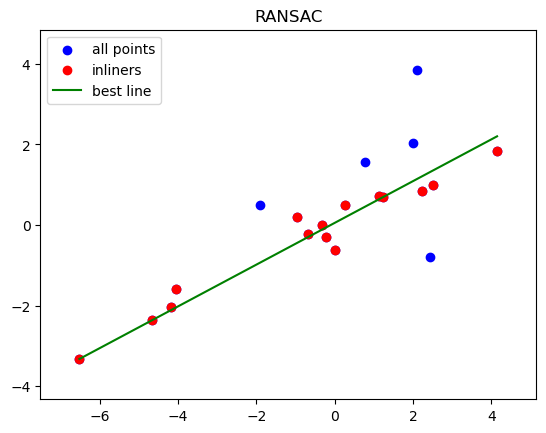

In [ ]:
visualize_ransac(pts, best_inliers, best_line)

## Ex 7.11

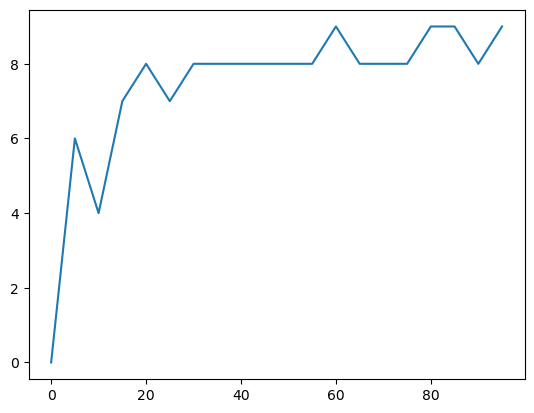

In [ ]:
# Test iterations
xpoints = []
ypoints = []

for i in range(0, 100, 5):
    xpoints.append(i)
    ypoints.append(RANSAC(pts, i, 0.2)[0])
xpoints = np.array(xpoints)
ypoints = np.array(ypoints)
plt.plot(xpoints, ypoints)
plt.show()

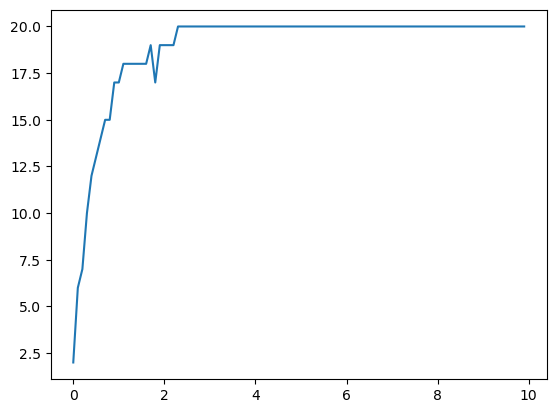

In [ ]:
# Test threshold
xpoints = []
ypoints = []

for i in range(0, 100, 1):
    xpoints.append(i/10)
    ypoints.append(RANSAC(pts, 10, i/10)[0])
xpoints = np.array(xpoints)
ypoints = np.array(ypoints)
plt.plot(xpoints, ypoints)
plt.show()

## Ex 7.12

In [ ]:
def pca_line(x): # assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l@x.mean(1)))
    return l

In [ ]:
x = np.concatenate((Pi(a), Pi(b)), axis=1)
x


array([[1., 3.],
       [2., 2.]])

In [ ]:
def RANSAC_PCA(pts: np.array, iterations: int, threshold: float):
    """
    Runs RANSAC for a number of iterations to find best model with the most amount of inliers
        Args:
            pts (np.array): set of pts. Expected shape (3 x N). Expect homogeneous points.
            iterations (int): number of iterations to run RANSAC
            threshold (float): threshold to determine whether a point is an inlier or outlier

        Return:
            most_inliers: most number of inliers
            best_inliers: best set of inliners
            best_line: line with the most number of inliers
    """
    most_inliers = 0
    best_line = np.zeros((3, ))
    best_inliers = []
    for _ in range(iterations): 
        pt_a, pt_b = sample_two_points(pts)
        line = fit_line(pt_a, pt_b)
        num_inliers, inliers = calculate_consensus(pts, line, threshold)
        if num_inliers > most_inliers:
            best_line = line
            most_inliers = num_inliers
            best_inliers = inliers
    best_line = pca_line(Pi(best_inliers.squeeze().T))
    return most_inliers, best_inliers, best_line

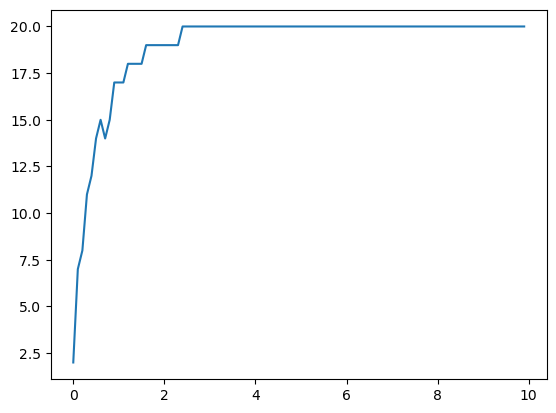

In [ ]:
# Test threshold
xpoints = []
ypoints = []

for i in range(0, 100, 1):
    xpoints.append(i / 10)
    ypoints.append(RANSAC_PCA(pts, 10, i / 10)[0])
xpoints = np.array(xpoints)
ypoints = np.array(ypoints)
plt.plot(xpoints, ypoints)
plt.show()

## Ex 7.13

In [ ]:
p = 0.99
def RANSAC_stop(pts: np.array, iterations: int, p: float, threshold: float):
    """
    Runs RANSAC for a number of iterations to find best model with the most amount of inliers
        Args:
            pts (np.array): set of pts. Expected shape (3 x N). Expect homogeneous points.
            iterations (int): number of iterations to ran RANSAC
            p (float): desired probability of success, specifically the probability that at least one of the random samples drawn during the algorithm’s iterations contains only inliers
            threshold (float): threshold to determine whether a point is an inlier or outlier

        Return:
            most_inliers: most number of inliers
            best_line: line with the most number of inliers
    """
    most_inliers = 0
    best_line = np.zeros((3,))
    best_inliers = []
    for i in range(iterations):
        pt_a, pt_b = sample_two_points(pts)
        line = fit_line(pt_a, pt_b)
        total_num_points = pts.shape[1]
        num_inliers, inliers = calculate_consensus(pts, line, threshold)
        if num_inliers > most_inliers:
            best_line = line
            most_inliers = num_inliers
            best_inliers = inliers
        estimate_outlier_prob = 1 - num_inliers/total_num_points
        # Squared because we are only sampling 2 points
        num_iterations = np.log(1 - p) / np.log(1 - ((1 - estimate_outlier_prob) ** 2))
        if i > num_iterations:
            print(f"Stopping early at iteration{i}")
    best_line = pca_line(Pi(best_inliers.squeeze().T))
    return most_inliers, best_inliers, best_line

/tmp/ipykernel_34507/2900488089.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  num_iterations = np.log(1 -p) / np.log(1 - ((1 - estimate_outlier_prob) ** 2))
/tmp/ipykernel_34507/2900488089.py:28: RuntimeWarning: divide by zero encountered in log
  num_iterations = np.log(1 -p) / np.log(1 - ((1 - estimate_outlier_prob) ** 2))


Stopping early at iteration0
Stopping early at iteration1
Stopping early at iteration2
Stopping early at iteration6
Stopping early at iteration7
Stopping early at iteration8
Stopping early at iteration10
Stopping early at iteration13
Stopping early at iteration14
Stopping early at iteration17
Stopping early at iteration19
Stopping early at iteration16
Stopping early at iteration18
Stopping early at iteration9
Stopping early at iteration13
Stopping early at iteration13
Stopping early at iteration16
Stopping early at iteration19
Stopping early at iteration6
Stopping early at iteration8
Stopping early at iteration10
Stopping early at iteration12
Stopping early at iteration13
Stopping early at iteration14
Stopping early at iteration15
Stopping early at iteration17
Stopping early at iteration10
Stopping early at iteration14
Stopping early at iteration15
Stopping early at iteration16
Stopping early at iteration18
Stopping early at iteration19
Stopping early at iteration6
Stopping early at it

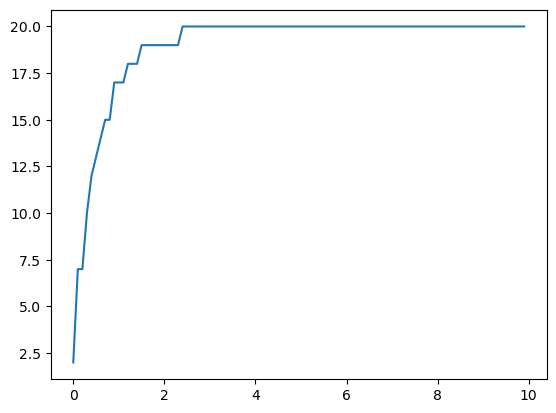

In [ ]:
# Test threshold
xpoints = []
ypoints = []
p = 0.99
for i in range(0, 100, 1):
    xpoints.append(i / 10)
    ypoints.append(RANSAC_stop(pts, 20, p, i / 10)[0])
xpoints = np.array(xpoints)
ypoints = np.array(ypoints)
plt.plot(xpoints, ypoints)
plt.show()